# Statsmodels buat ngecek regresi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',False)
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv('data_bersih_ver3.csv')
df = df[df['tipe']=='Rumah']
df = df.drop(['Unnamed: 0','tipe'], axis = 1)
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12765 entries, 0 to 13495
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    12765 non-null  int64  
 1   kamar_tidur    12765 non-null  int64  
 2   luas_bangunan  12765 non-null  float64
 3   luas_tanah     12765 non-null  float64
 4   harga          12765 non-null  float64
 5   kecamatan      12765 non-null  object 
 6   garasi         12765 non-null  bool   
 7   kolam_renang   12765 non-null  bool   
 8   taman          12765 non-null  bool   
 9   gym            12765 non-null  bool   
 10  listrik        12765 non-null  float64
 11  jumlah_lantai  12765 non-null  int64  
dtypes: bool(4), float64(4), int64(3), object(1)
memory usage: 947.4+ KB


In [3]:
from feature_engine.outliers import OutlierTrimmer as OT

In [4]:
trimer =capper = OT(
    capping_method ='iqr', 
    tail = 'right', 
    fold = 3, 
    variables = ['harga']
)
trimer.fit(df)

OutlierTrimmer(capping_method='iqr', variables=['harga'])

In [5]:
df = trimer.transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11821 entries, 0 to 13495
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    11821 non-null  int64  
 1   kamar_tidur    11821 non-null  int64  
 2   luas_bangunan  11821 non-null  float64
 3   luas_tanah     11821 non-null  float64
 4   harga          11821 non-null  float64
 5   kecamatan      11821 non-null  object 
 6   garasi         11821 non-null  bool   
 7   kolam_renang   11821 non-null  bool   
 8   taman          11821 non-null  bool   
 9   gym            11821 non-null  bool   
 10  listrik        11821 non-null  float64
 11  jumlah_lantai  11821 non-null  int64  
dtypes: bool(4), float64(4), int64(3), object(1)
memory usage: 877.3+ KB


In [6]:
df['kecamatan'].nunique()

42

In [7]:
num = [i for i in df.columns if df[i].dtypes in ['int64', 'float']]
cat = [i for i in df.columns if df[i].dtypes in ['O', 'bool']]

In [8]:
df[cat] = df[cat].astype('O')

In [9]:
from feature_engine.encoding import OrdinalEncoder as OE

In [10]:
oe = OE(variables = [i for i in cat])
oe.fit(df,df['harga'])

OrdinalEncoder(variables=['kecamatan', 'garasi', 'kolam_renang', 'taman',
                          'gym'])

In [11]:
x = oe.transform(df)

In [12]:
from sklearn.preprocessing import StandardScaler as ss

In [13]:
x_scale = ss()
x_scale.fit(x.drop('harga',axis = 1))
y_scale = ss()
y_scale.fit(x[['harga']])

StandardScaler()

In [14]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11821 entries, 0 to 13495
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    11821 non-null  int64  
 1   kamar_tidur    11821 non-null  int64  
 2   luas_bangunan  11821 non-null  float64
 3   luas_tanah     11821 non-null  float64
 4   harga          11821 non-null  float64
 5   kecamatan      11821 non-null  int64  
 6   garasi         11821 non-null  int64  
 7   kolam_renang   11821 non-null  int64  
 8   taman          11821 non-null  int64  
 9   gym            11821 non-null  int64  
 10  listrik        11821 non-null  float64
 11  jumlah_lantai  11821 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 1.2 MB


In [15]:
import statsmodels.api as sm

In [16]:
x = x_scale.transform(x.drop(['harga'],axis = 1))
x = pd.DataFrame(x)
x.columns = df.drop('harga', axis = 1).columns

y = y_scale.transform(df[['harga']])
y = pd.DataFrame(y)
y.columns = ['harga']
initial_data = pd.concat([x,y],axis = 1)
x = sm.add_constant(x)

In [17]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  harga   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     2050.
Date:                Sat, 22 May 2021   Prob (F-statistic):               0.00
Time:                        10:57:05   Log-Likelihood:                -10460.
No. Observations:               11821   AIC:                         2.094e+04
Df Residuals:                   11809   BIC:                         2.103e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.633e-17      0.005  -1.41e-14      1.000      -0.011       0.011
kamar_mandi       0.0764      0.008      9.460      0.000       0.061       0.092
kamar_tidur       0.0170      0.008      2.245      0.025       0.002       0.032
luas_bangunan     0.3913      0.009     44.954      0.000       0.374       0.408
luas_tanah        0.2580      0.008     32.421      0.000       0.242       0.274
kecamatan         0.2833      0.006     48.863      0.000       0.272       0.295
garasi           -0.0318      0.006     -5.655      0.000      -0.043      -0.021
kolam_renang      0.1013      0.006     17.669      0.000       0.090       0.113
taman             0.0195      0.005      3.558      0.000       0.009       0.030
gym              -0.0105      0.005     -1.902      0.057      -0.021       0.000
listrik           0.0201      0.006      3.642      0.000       0.009       0.031
jumlah_lantai    -0.0091      0.006     -1.554      0.120      -0.020       0.002
==============================================================================
Omnibus:                    12553.755   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14854866.916
Skew:                          -4.359   Prob(JB):                         0.00
Kurtosis:                     176.446   Cond. No.                         3.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
pd.DataFrame(model.params).reset_index().sort_values(by = 0, ascending = False)

,index,0
3,luas_bangunan,3.912804e-01
5,kecamatan,2.832727e-01
4,luas_tanah,2.579833e-01
7,kolam_renang,1.013328e-01
1,kamar_mandi,7.640077e-02
10,listrik,2.011254e-02
8,taman,1.949782e-02
2,kamar_tidur,1.703530e-02
0,const,-7.632783e-17
11,jumlah_lantai,-9.059724e-03


In [19]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [20]:
y_pred = model.predict(x)
sqrt(mse(y_pred, y))

0.5862251824232015

In [21]:
from scipy import stats

In [22]:
for k in cat+num:
    if df[k].nunique() <100:
        print("="*45,f' {k} ',"="*45)
        var = [i for i in df[k].unique()]
        pair = {}
        udah = []
        for i in var:
            for j in var:
                if (j not in udah) & (i != j):
                    ttest = stats.ttest_ind(a = df[df[k] == i]['harga'],
                                            b = df[df[k] == j]['harga'])
                    p_value = ttest.pvalue
                    pair[f'{i} - {j}'] = p_value
            udah.append(i)
        count = 0
        for i,j in pair.items():
            if j >= 0.05:
                print(i)
                count += 1
        print(f'{k}: {count/len(pair)*100}')
        print("="*100,end = '\n')

=============================================  kecamatan  =============================================
Mampang Prapatan - Kebayoran Baru
Mampang Prapatan - Kebayoran Lama
Mampang Prapatan - Menteng
Cilandak - Setiabudi
Cilandak - Pancoran
Cilandak - Penjaringan
Cilandak - Jatinegara
Cilandak - Tanah Abang
Cilandak - Gambir
Kebayoran Baru - Kebayoran Lama
Jagakarsa - Koja
Jagakarsa - Cakung
Jagakarsa - Kramat Jati
Jagakarsa - Makasar
Jagakarsa - Sawah Besar
Jagakarsa - Johar Baru
Jagakarsa - Kalideres
Tebet - Pasar Minggu
Tebet - Pademangan
Tebet - Pulo Gadung
Tebet - Jatinegara
Tebet - Kemayoran
Tebet - Cempaka Putih
Tebet - Palmerah
Tebet - Kembangan
Tebet - Tambora
Pesanggrahan - Tanjung Priok
Pesanggrahan - Kelapa Gading
Pesanggrahan - Pademangan
Pesanggrahan - Kemayoran
Pesanggrahan - Senen
Pesanggrahan - Grogol Petamburan
Pesanggrahan - Kebon Jeruk
Pesanggrahan - Tambora
Pesanggrahan - Taman Sari
Pasar Minggu - Jatinegara
Pasar Minggu - Gambir
Pasar Minggu - Palmerah
Kebayoran La

# EDA

kamar_mandi


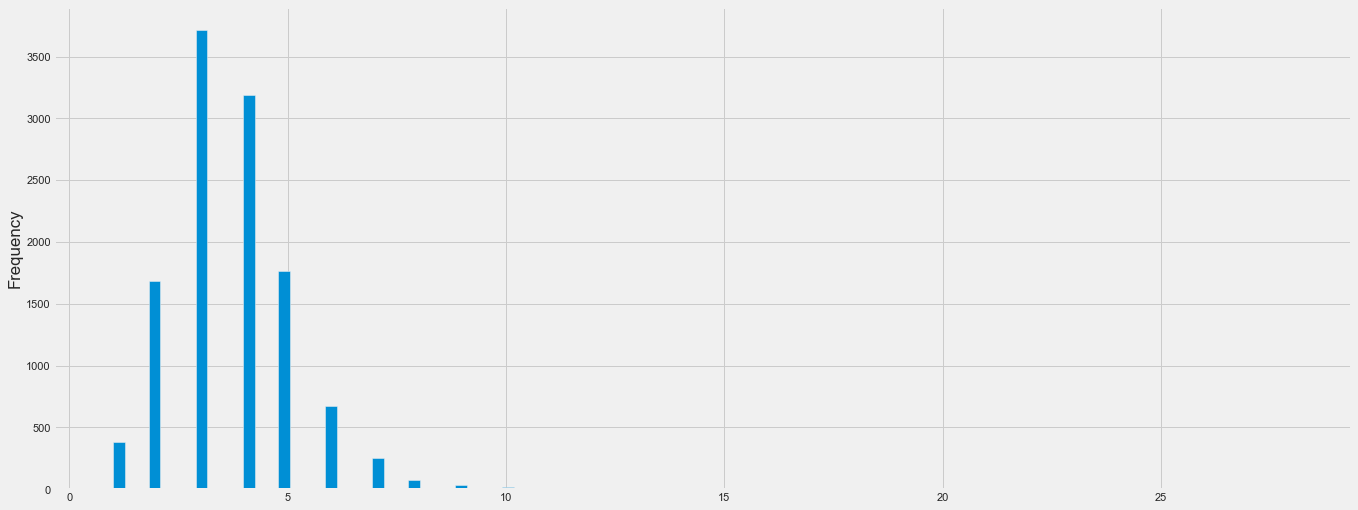

kamar_tidur


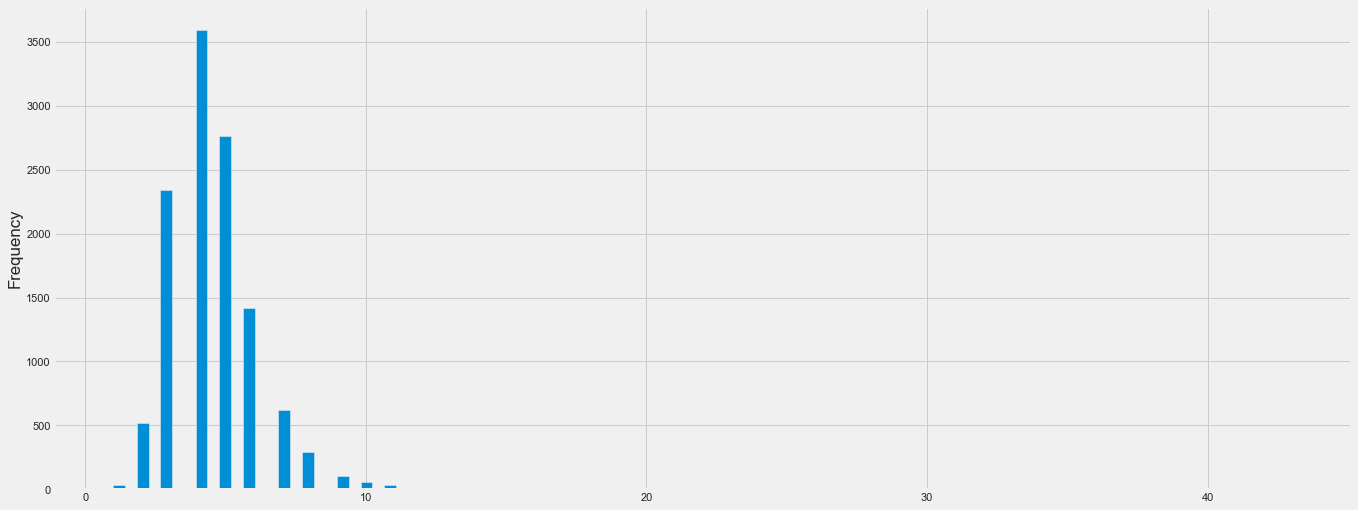

luas_bangunan


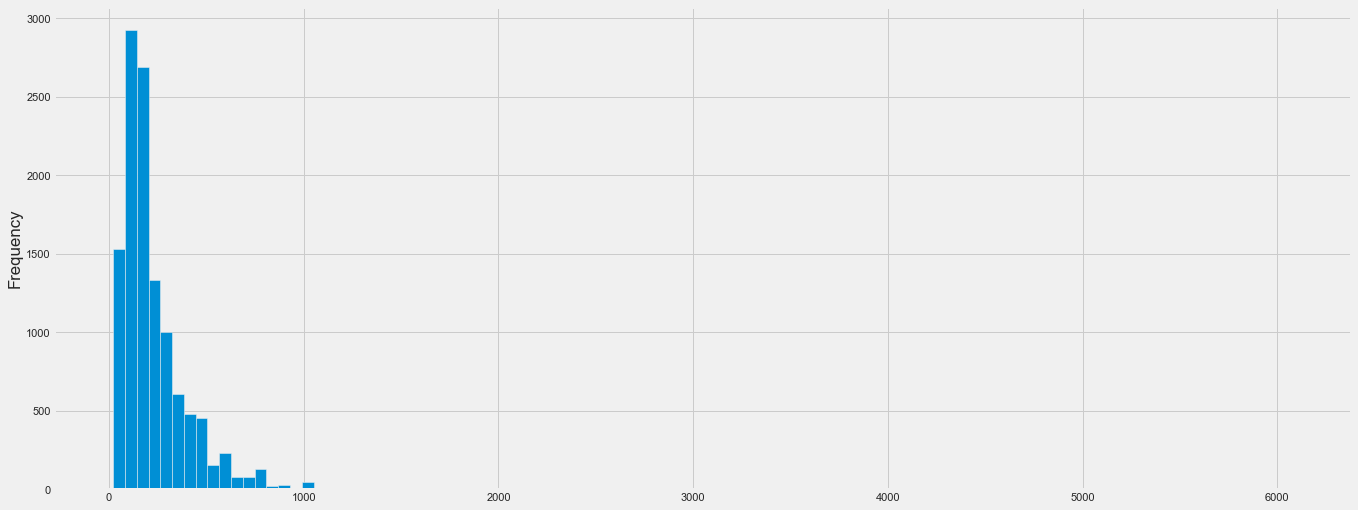

luas_tanah


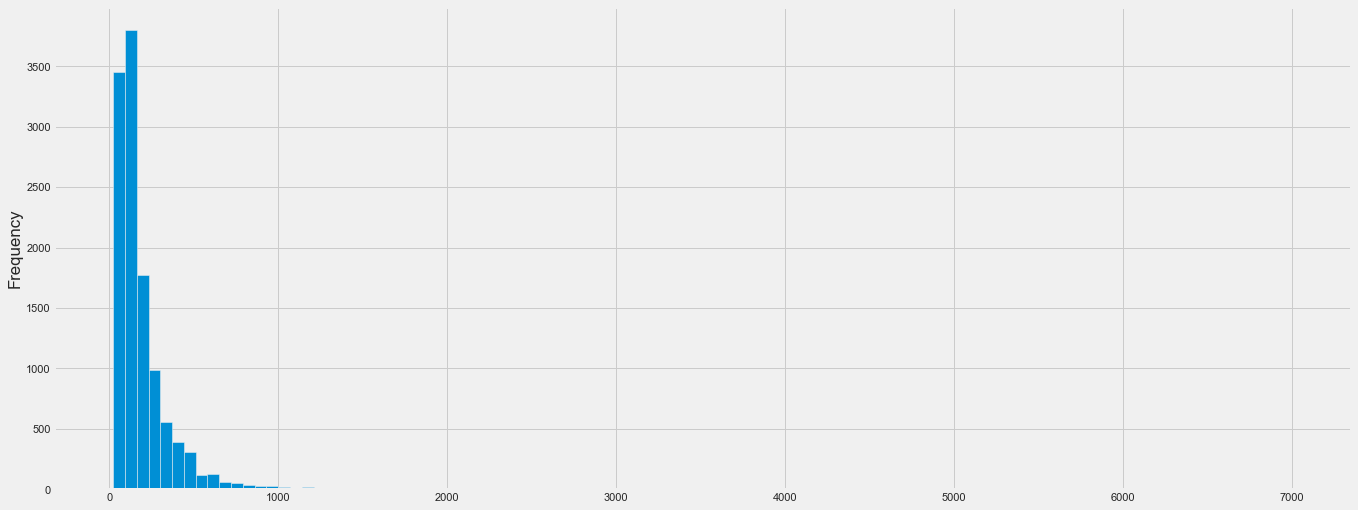

harga


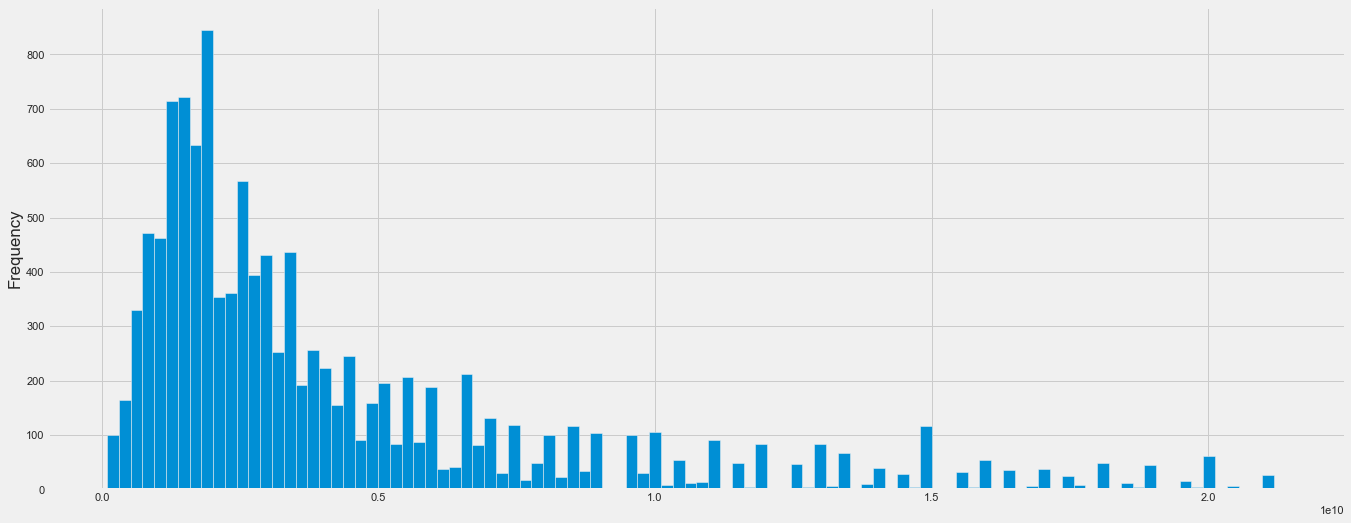

listrik


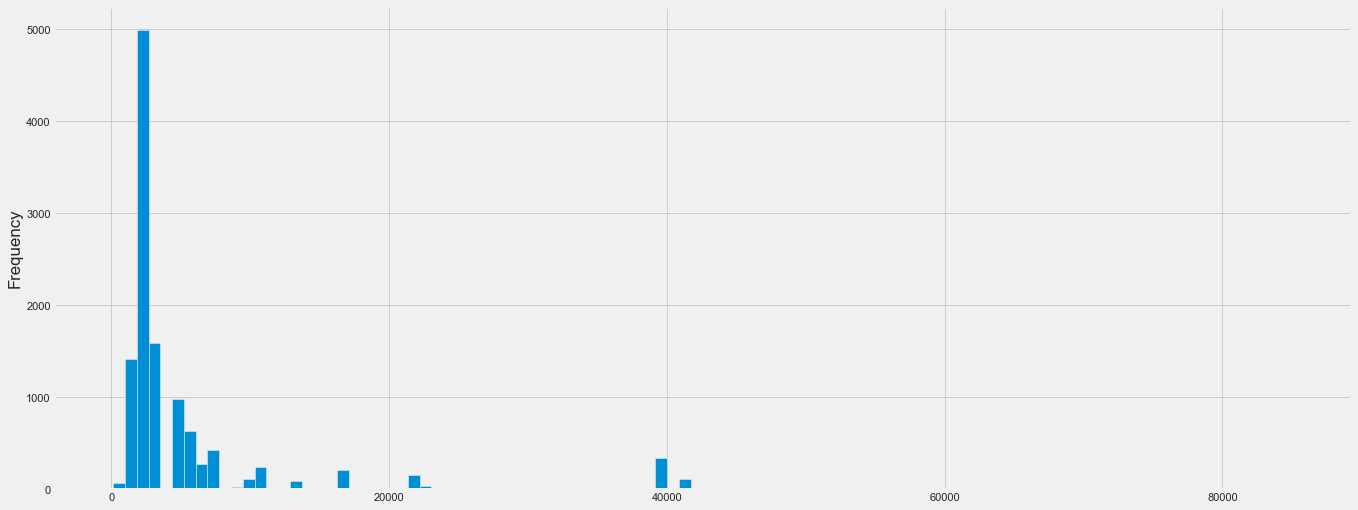

jumlah_lantai


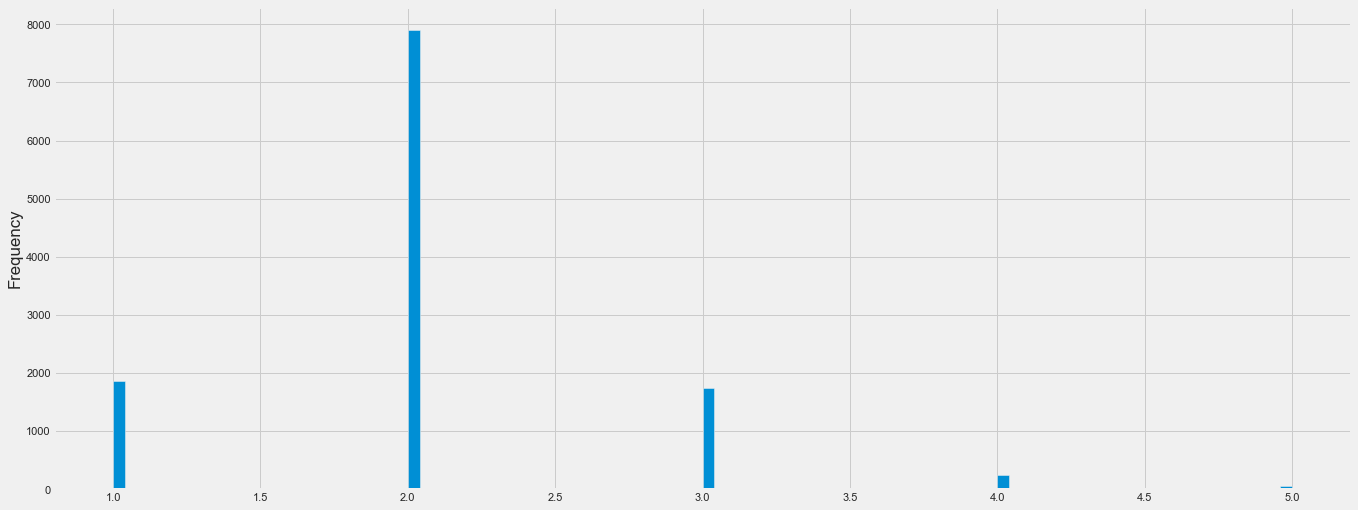

In [23]:
for i in num:
    print(i)
    df[i].plot.hist(bins = 100)
    plt.show()

kamar_mandi


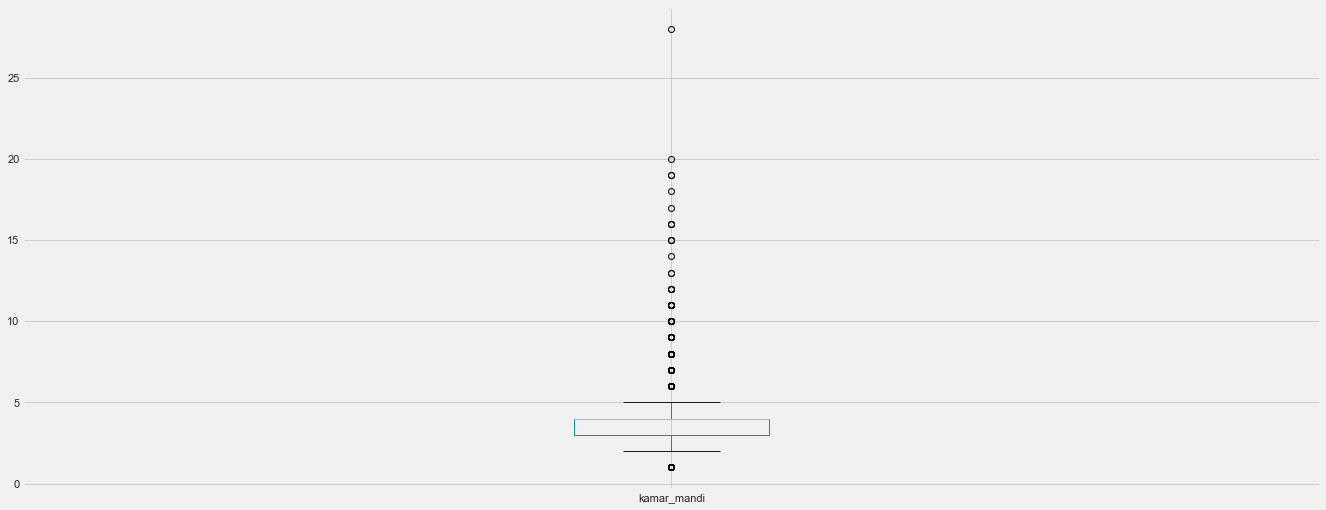

kamar_tidur


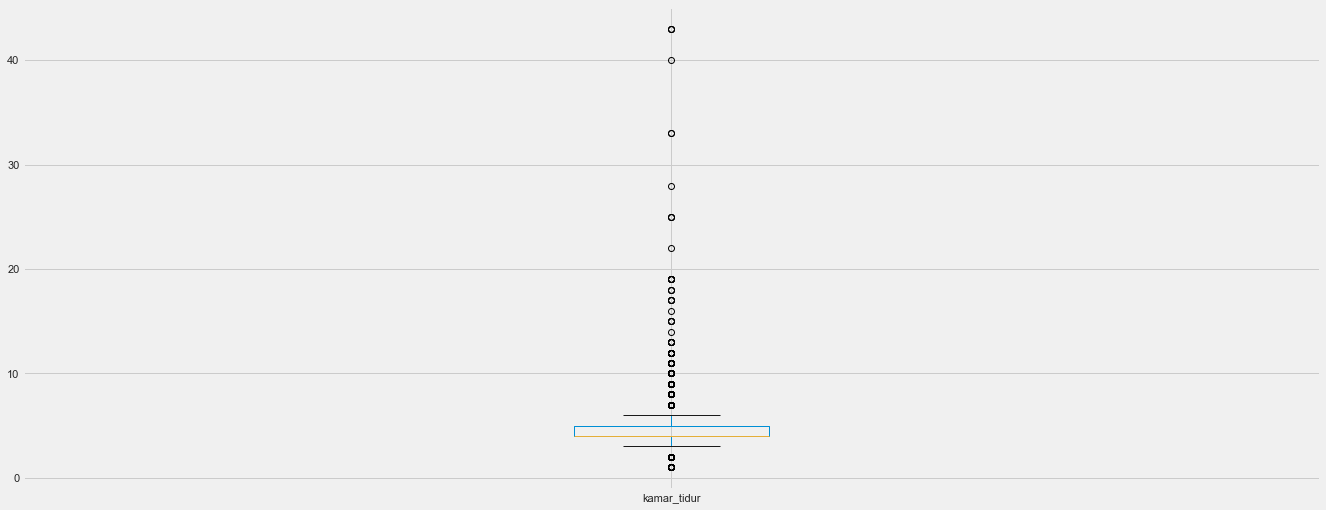

luas_bangunan


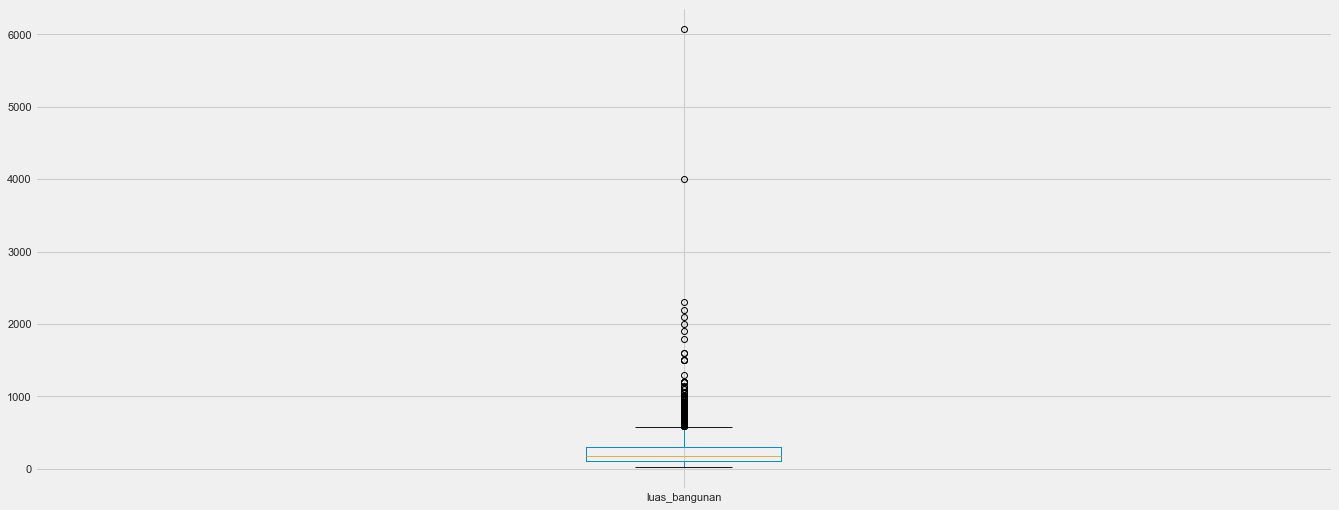

luas_tanah


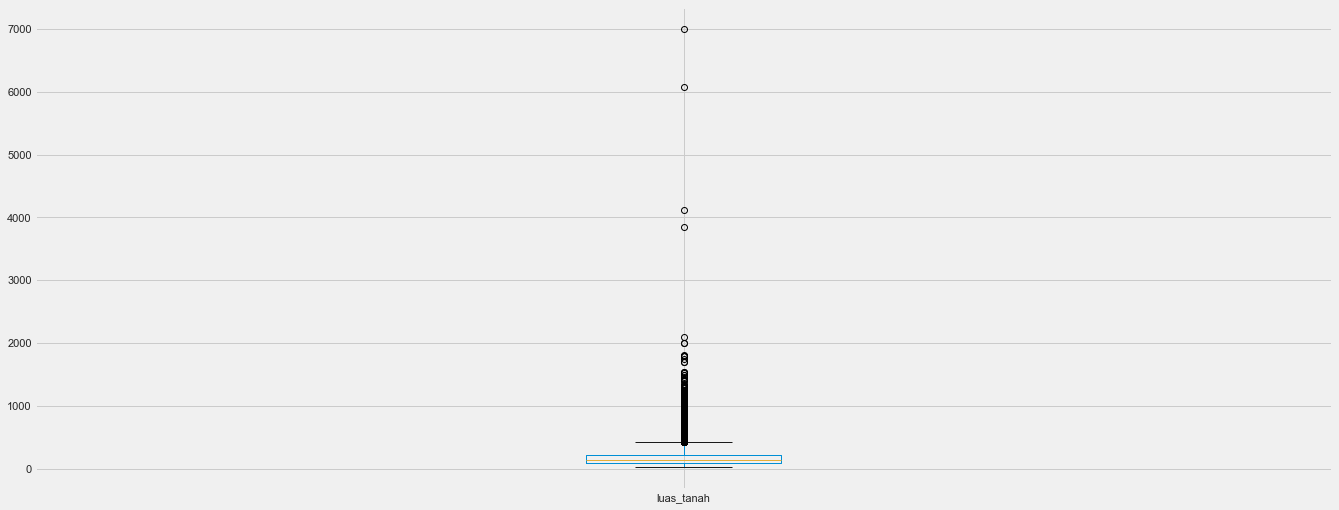

harga


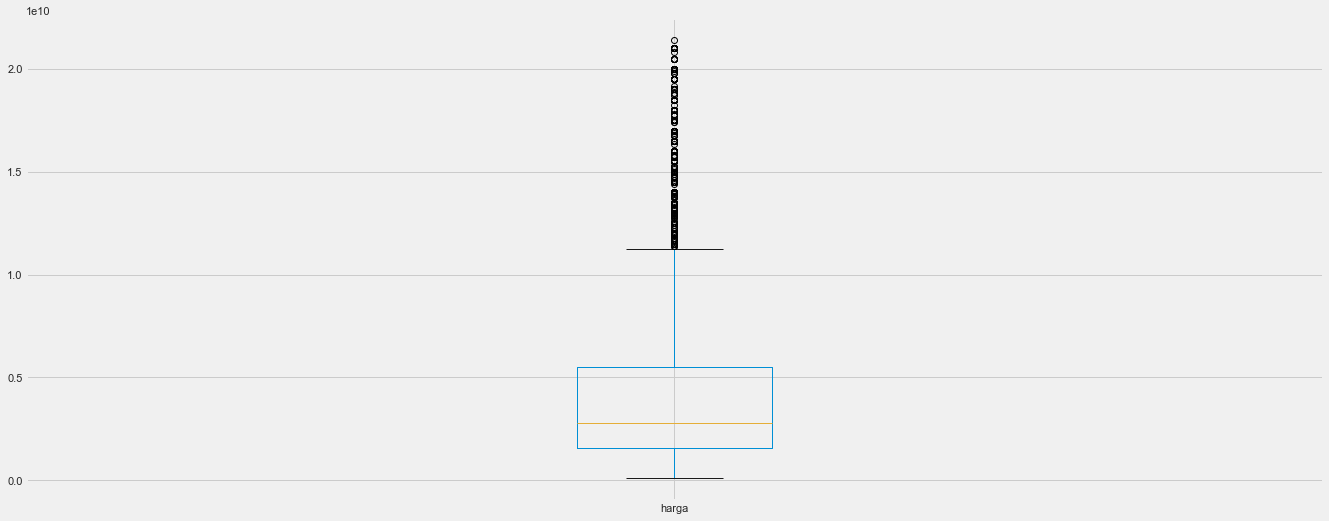

listrik


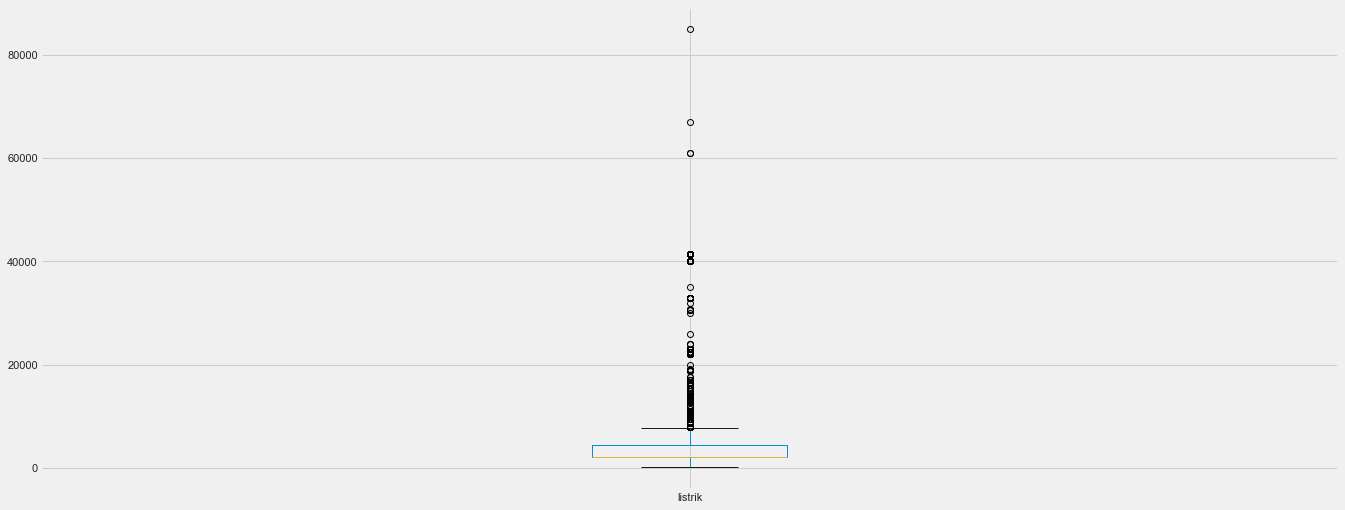

jumlah_lantai


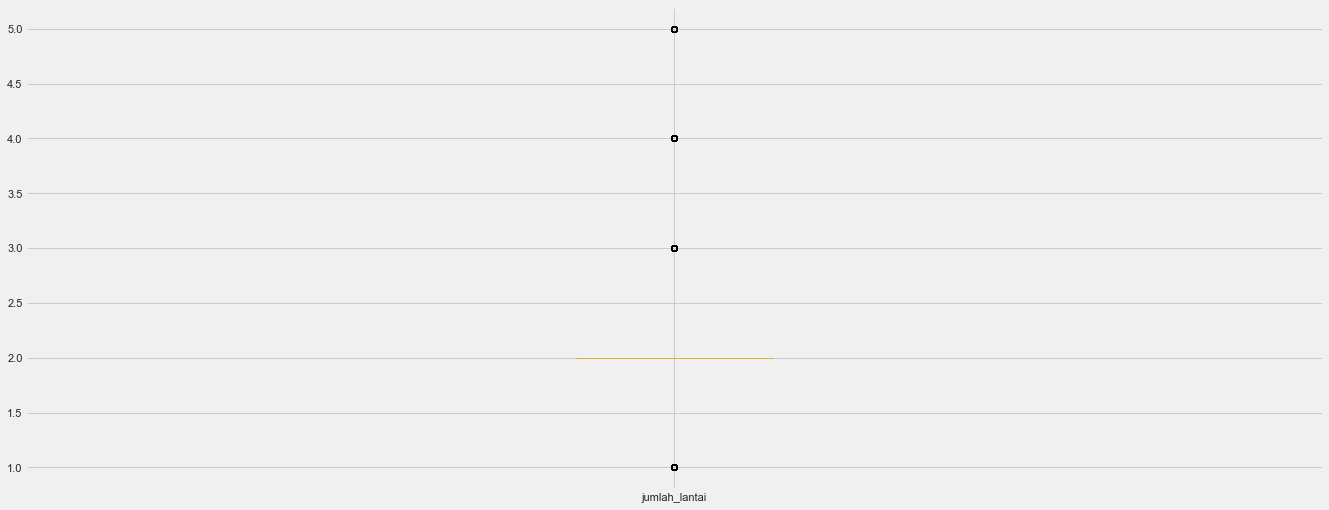

In [24]:
for i in num:
    print(i)
    df[i].plot.box()
    plt.show()

kecamatan


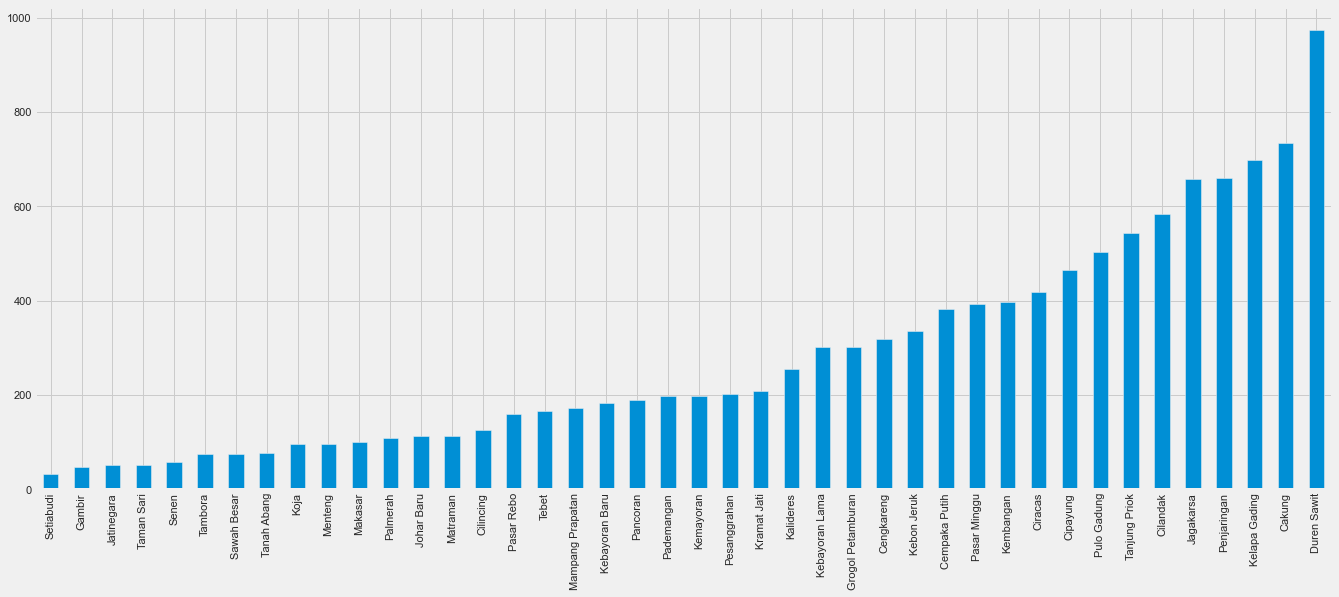

garasi


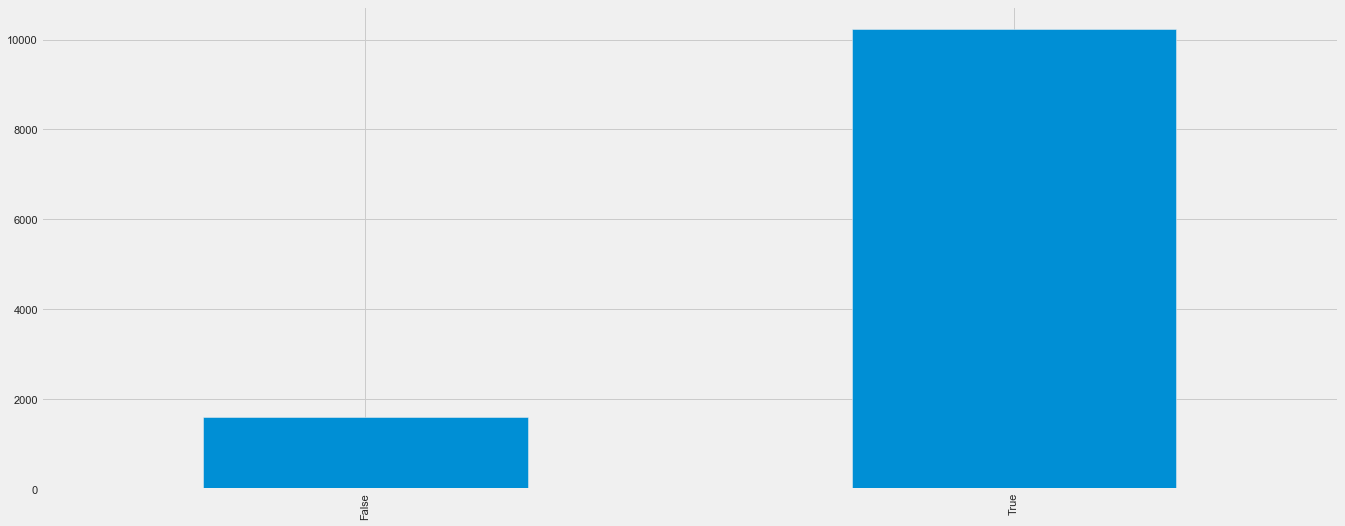

kolam_renang


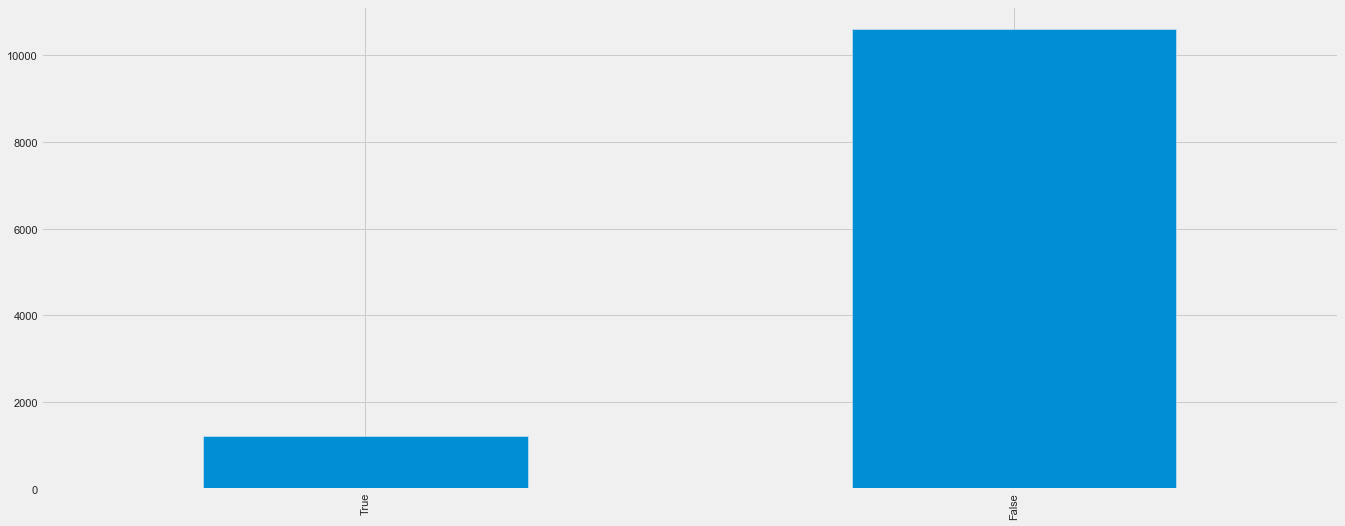

taman


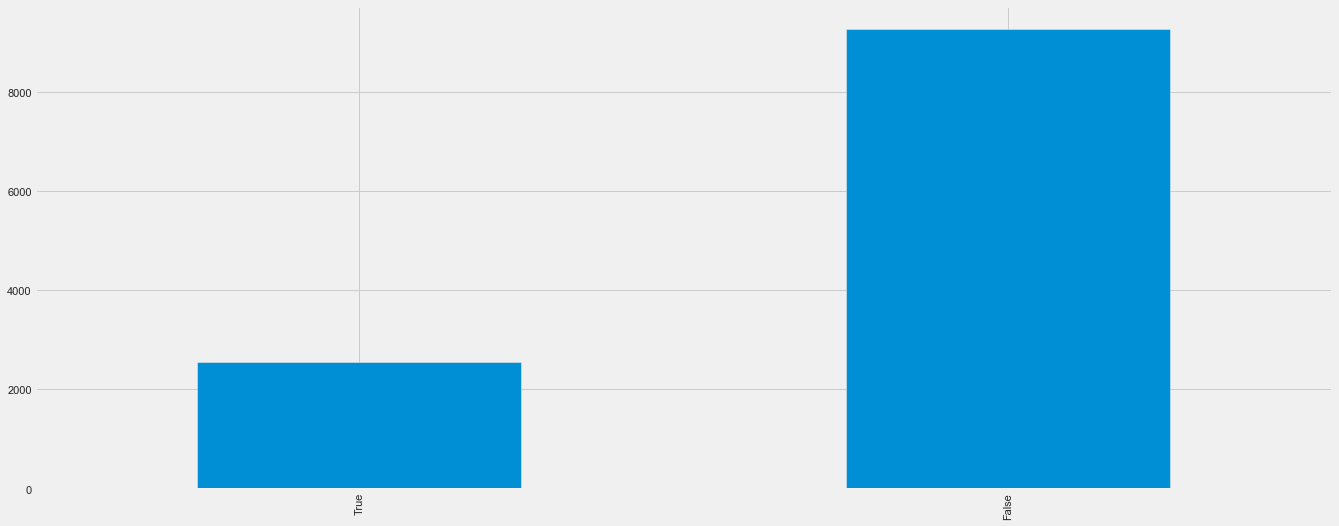

gym


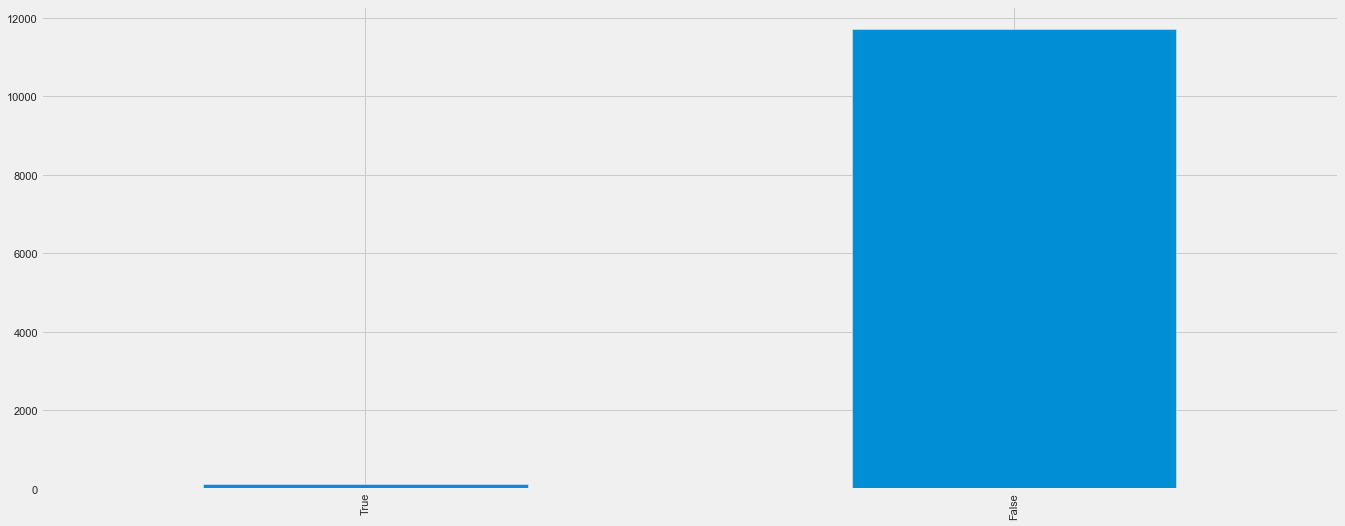

In [25]:
for i in cat:
    print(i)
    df[i].value_counts().sort_values().plot.bar()
    plt.show()

Masukin target (harga)

kamar_mandi


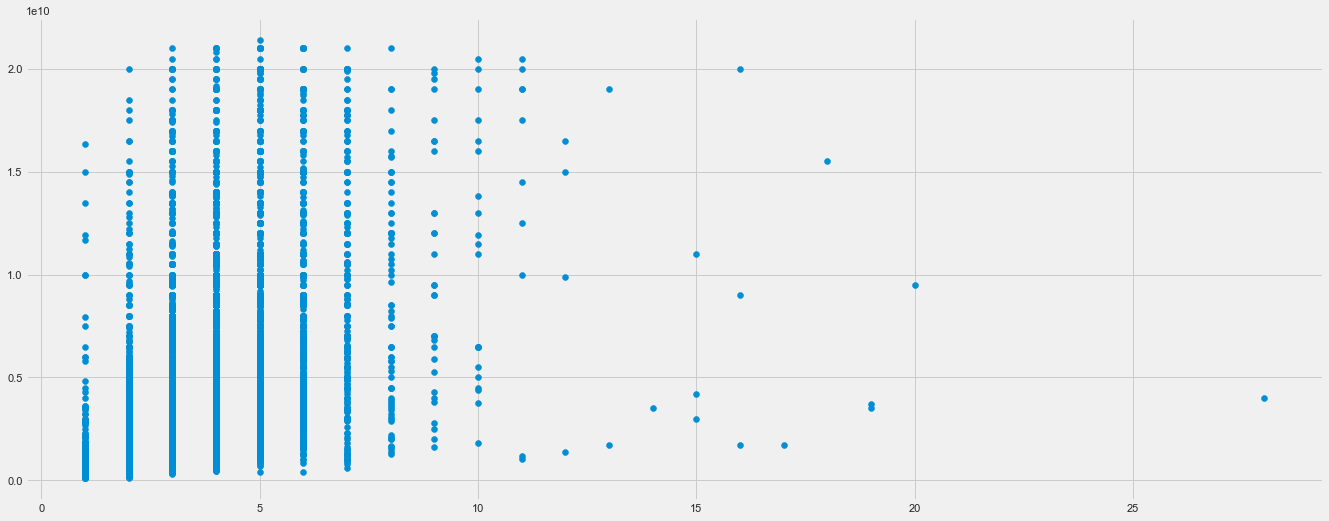

kamar_tidur


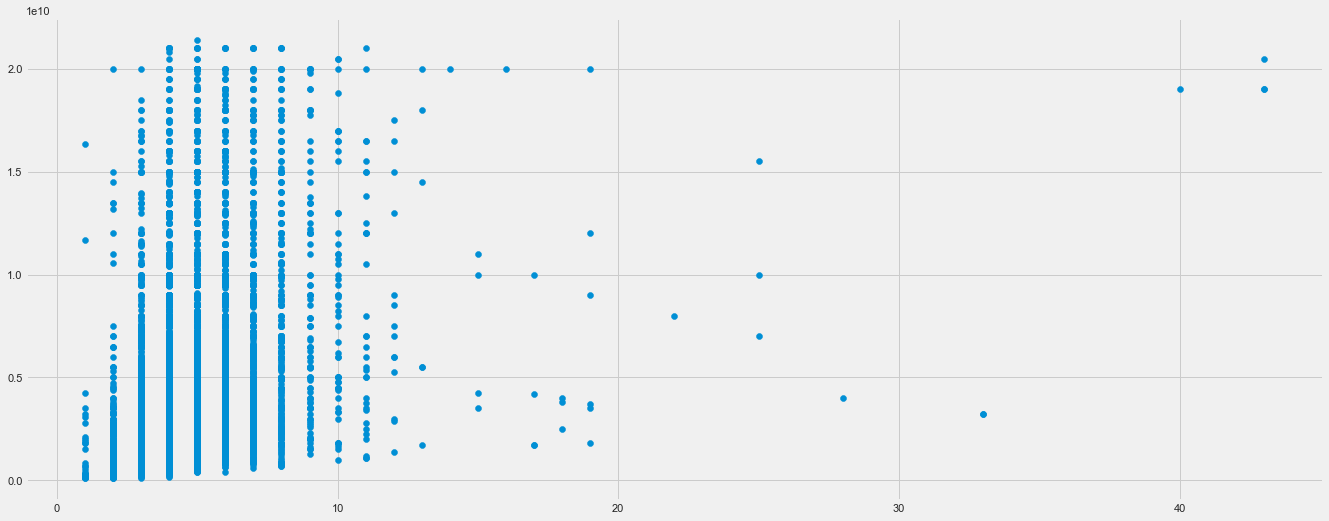

luas_bangunan


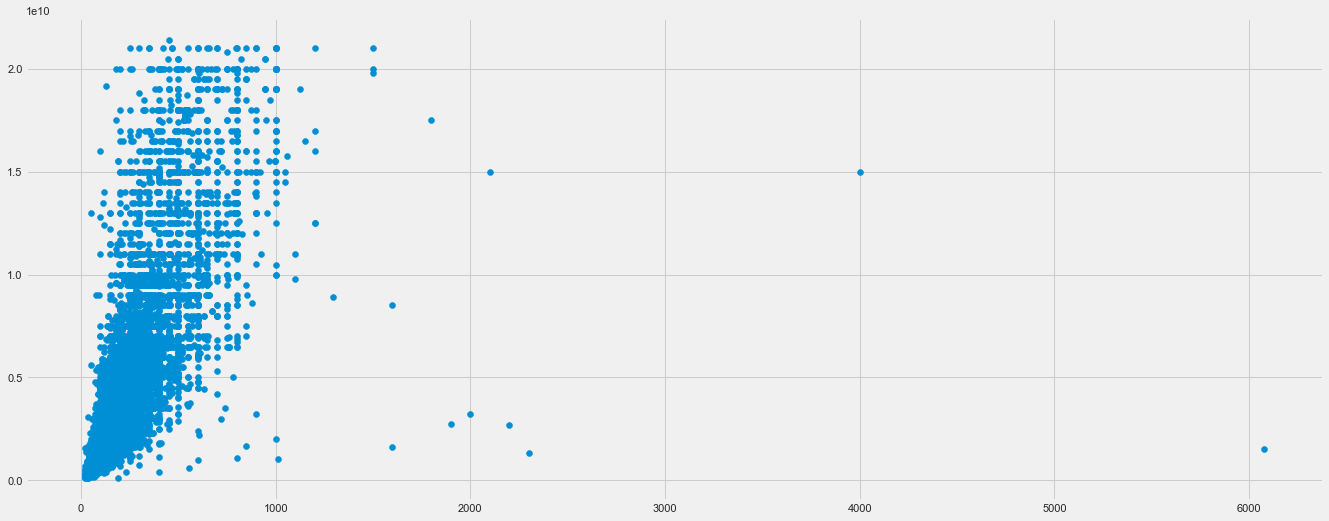

luas_tanah


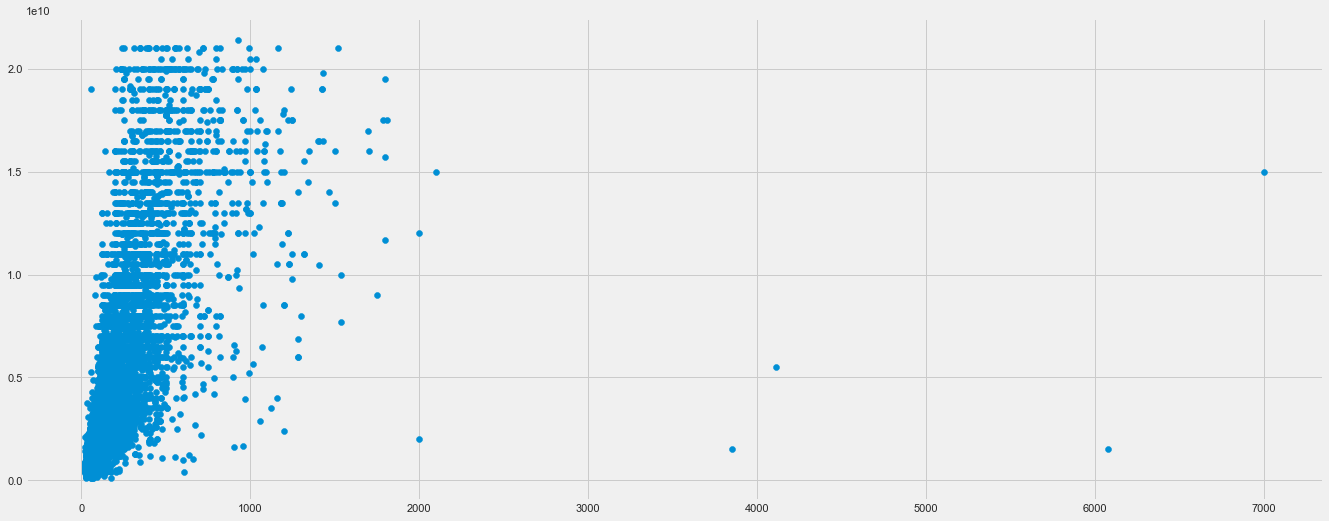

listrik


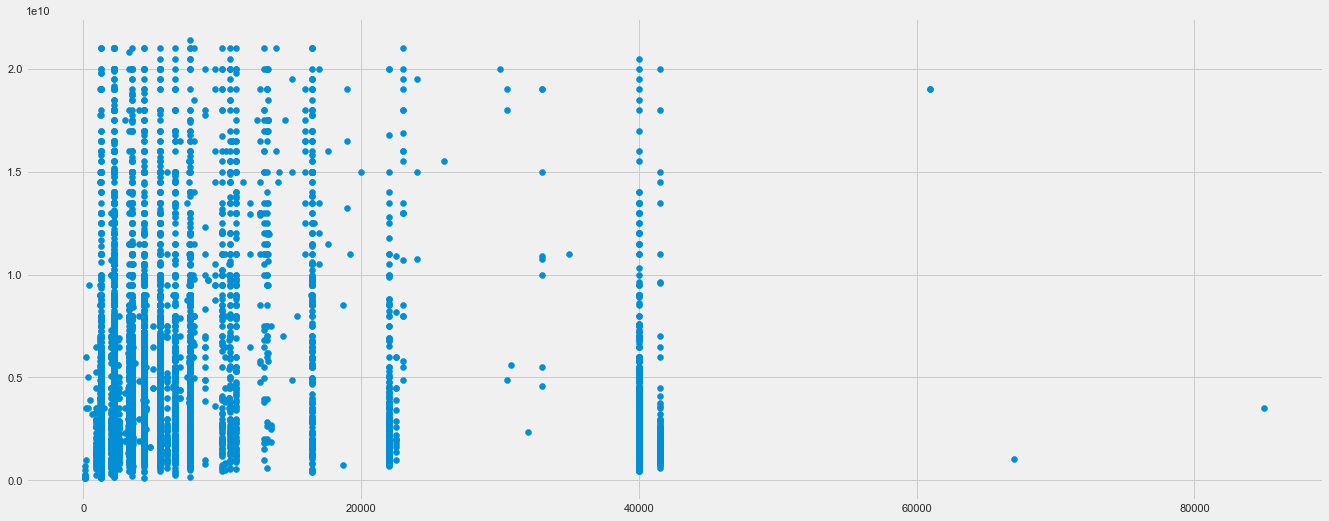

jumlah_lantai


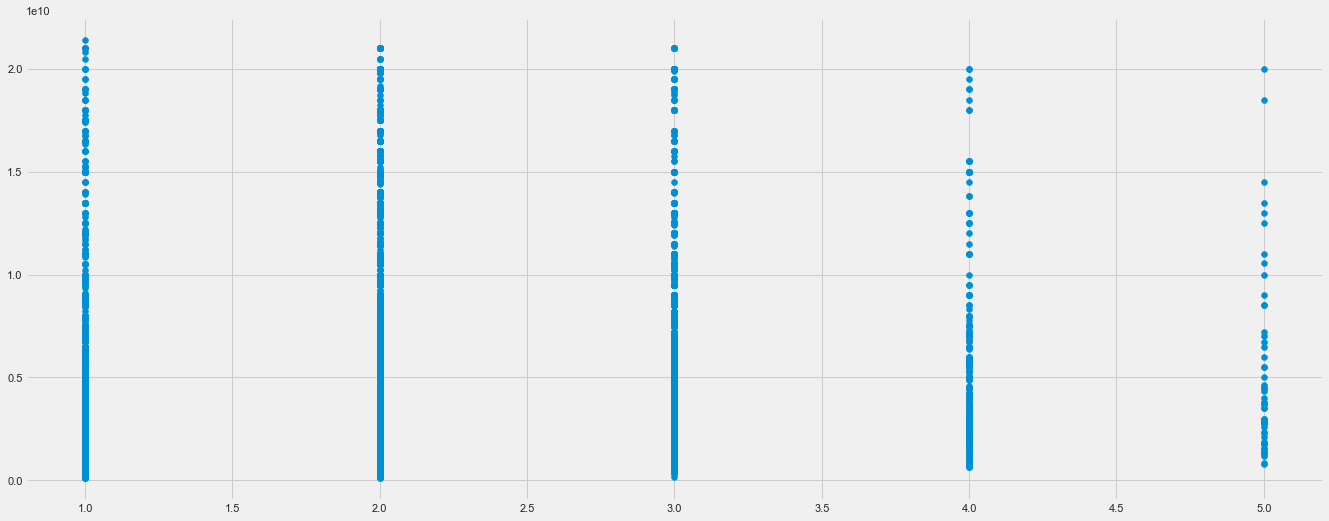

kecamatan


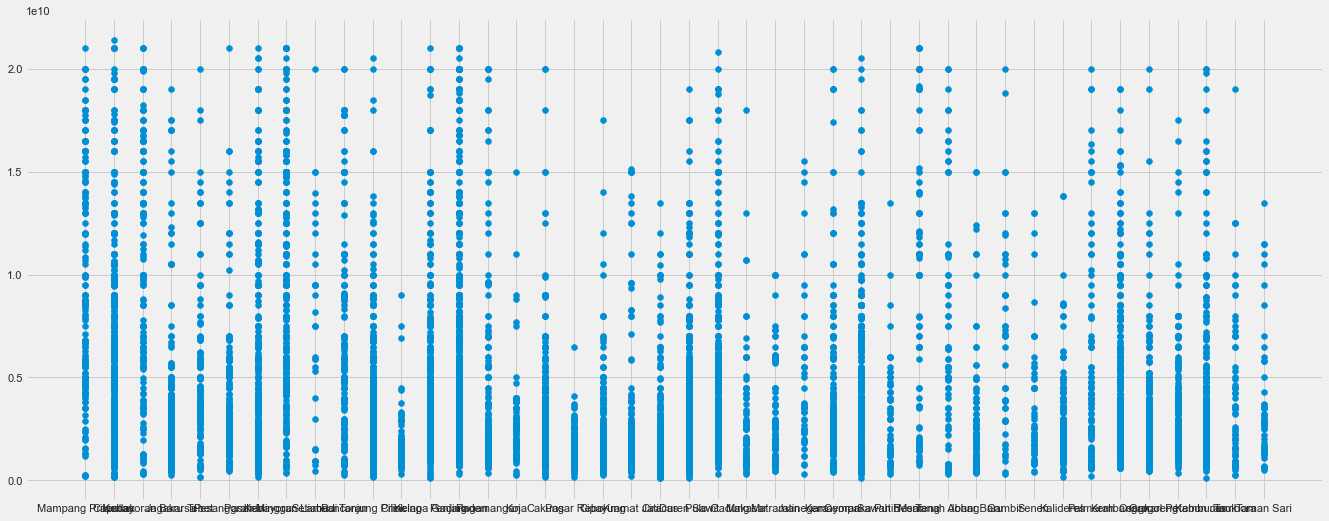

garasi


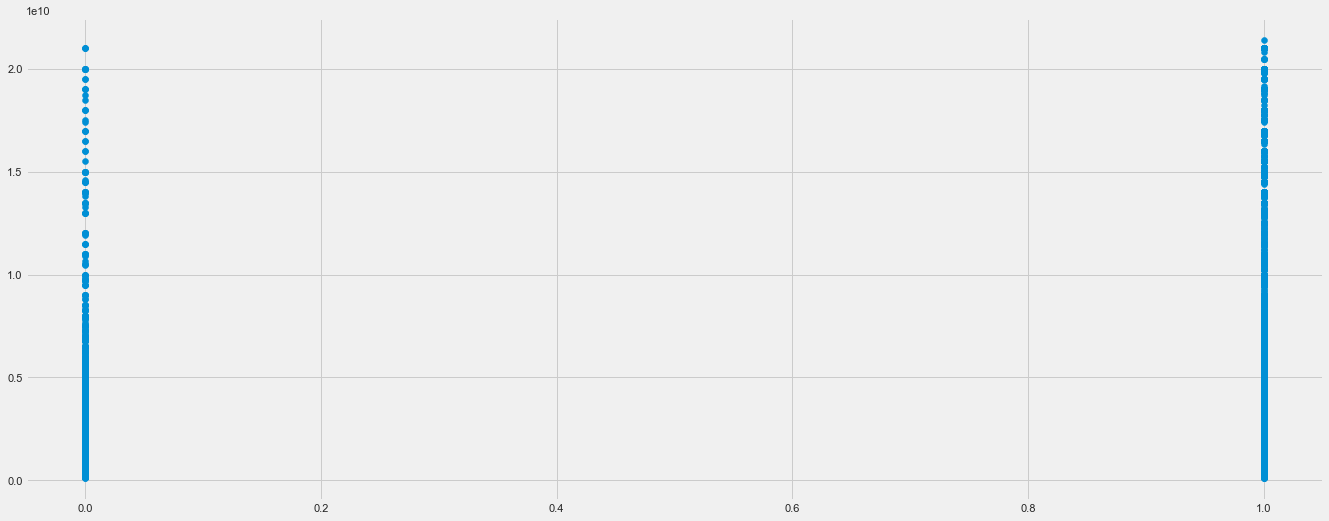

kolam_renang


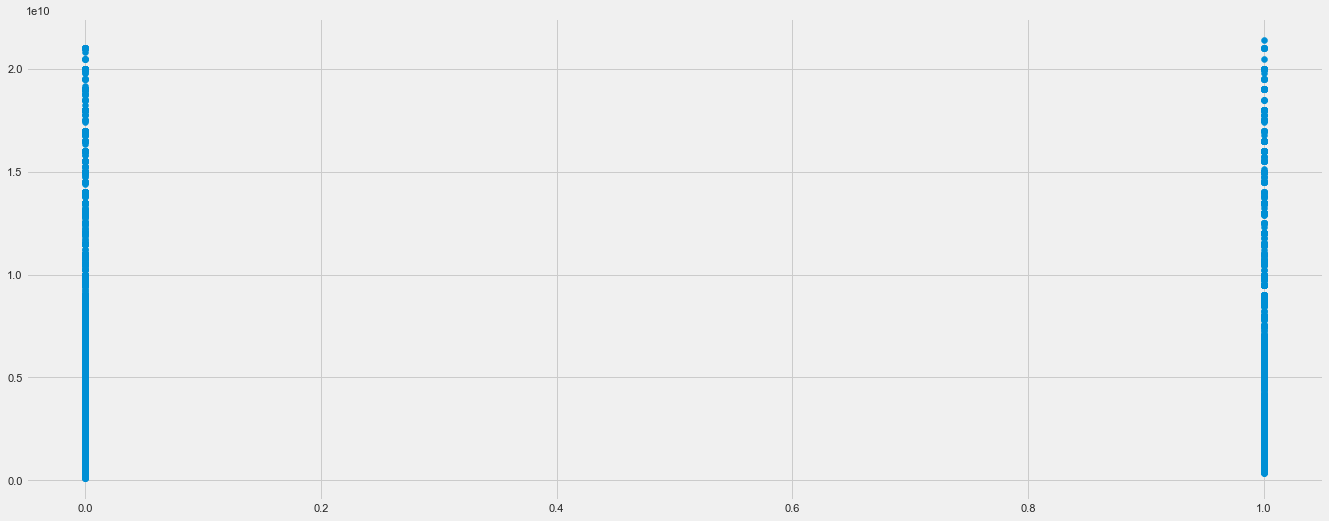

taman


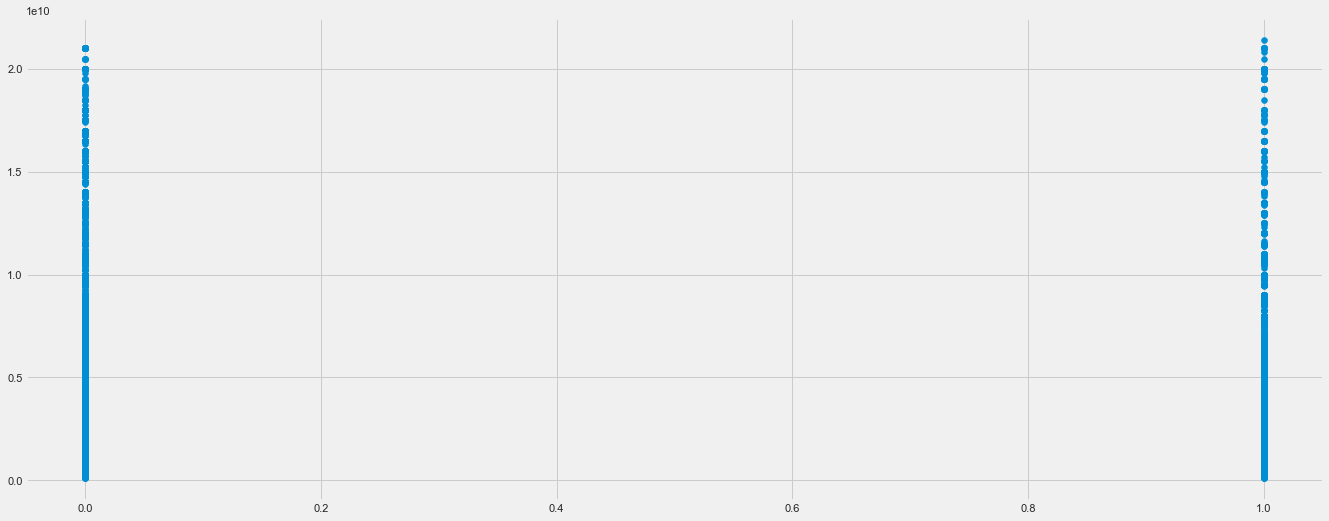

gym


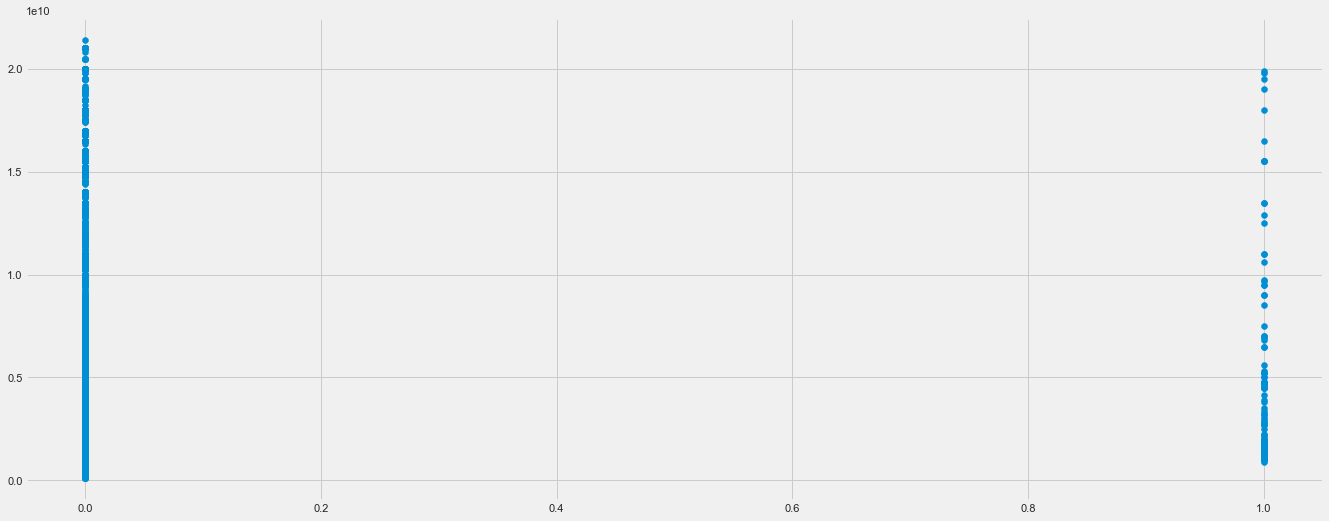

In [26]:
for i in num+cat:
    if i != 'harga':
        print(i)
        plt.scatter(df[i],df['harga'])
        plt.show()

kecamatan


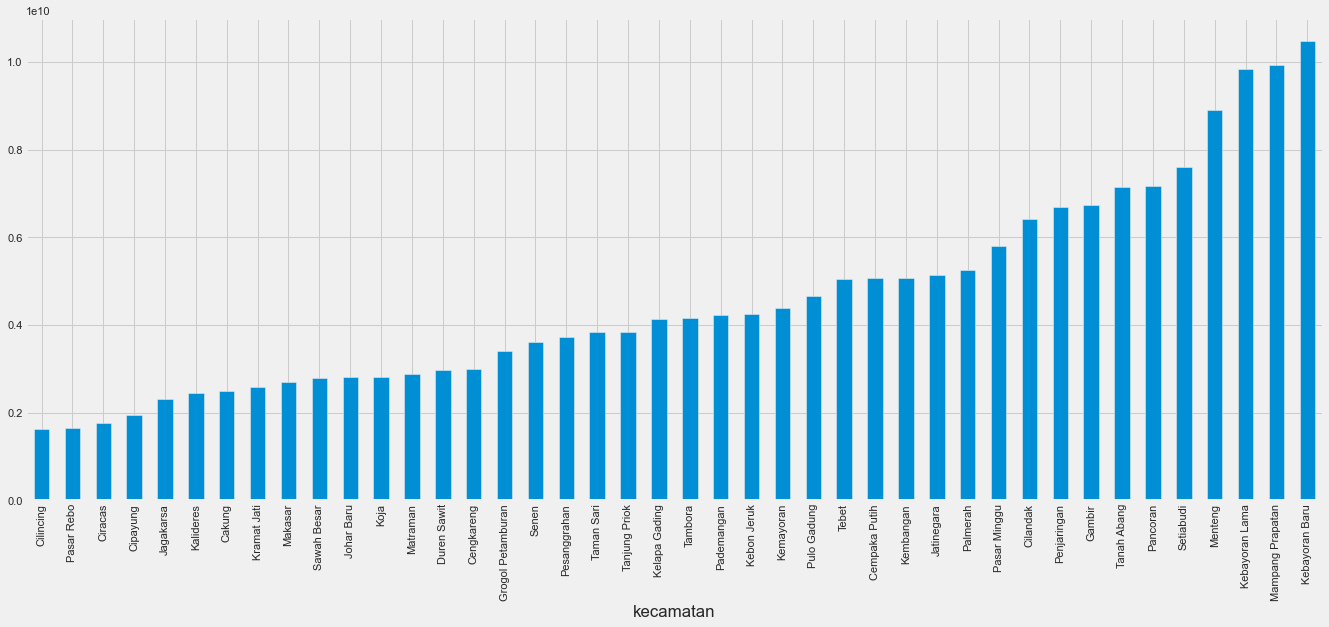

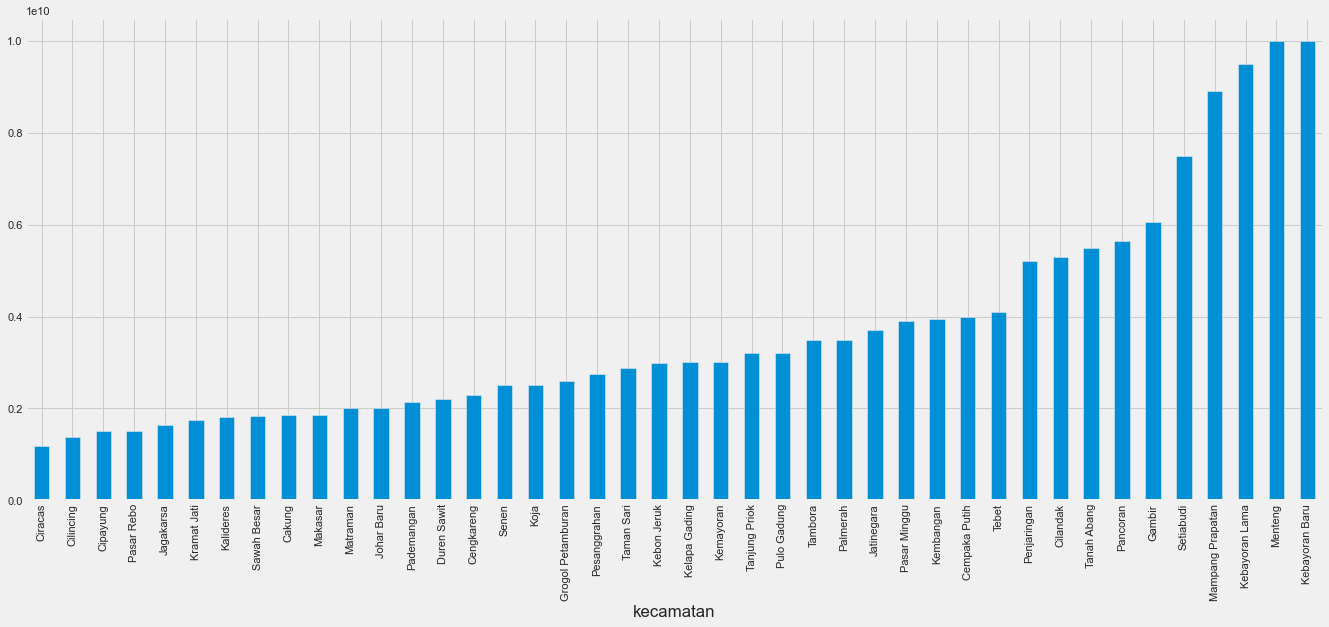

garasi


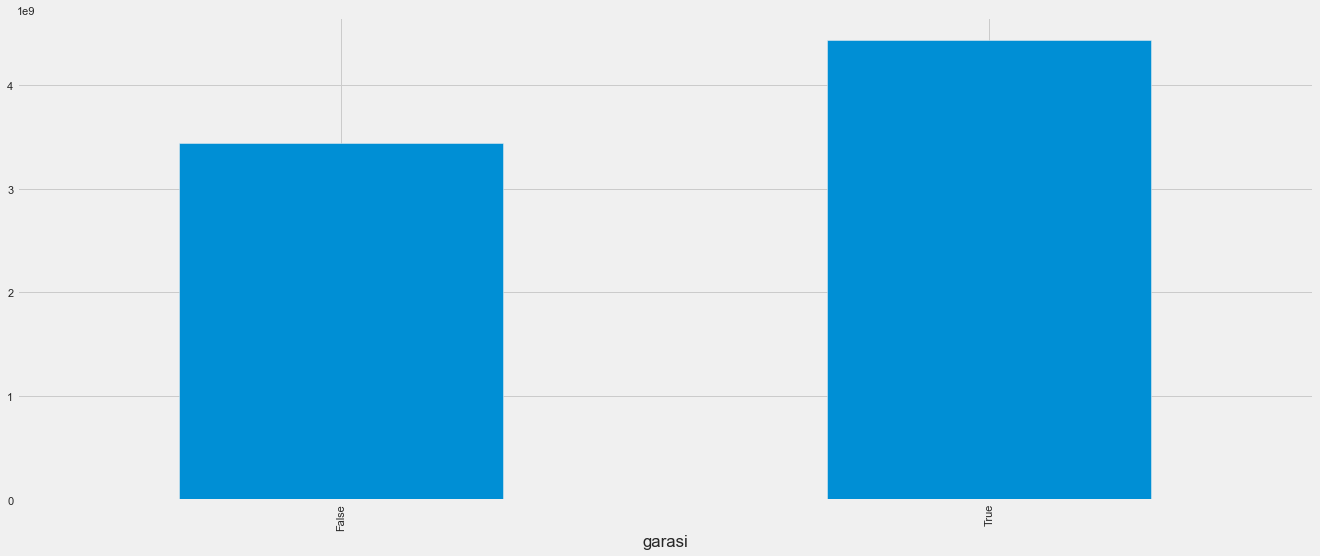

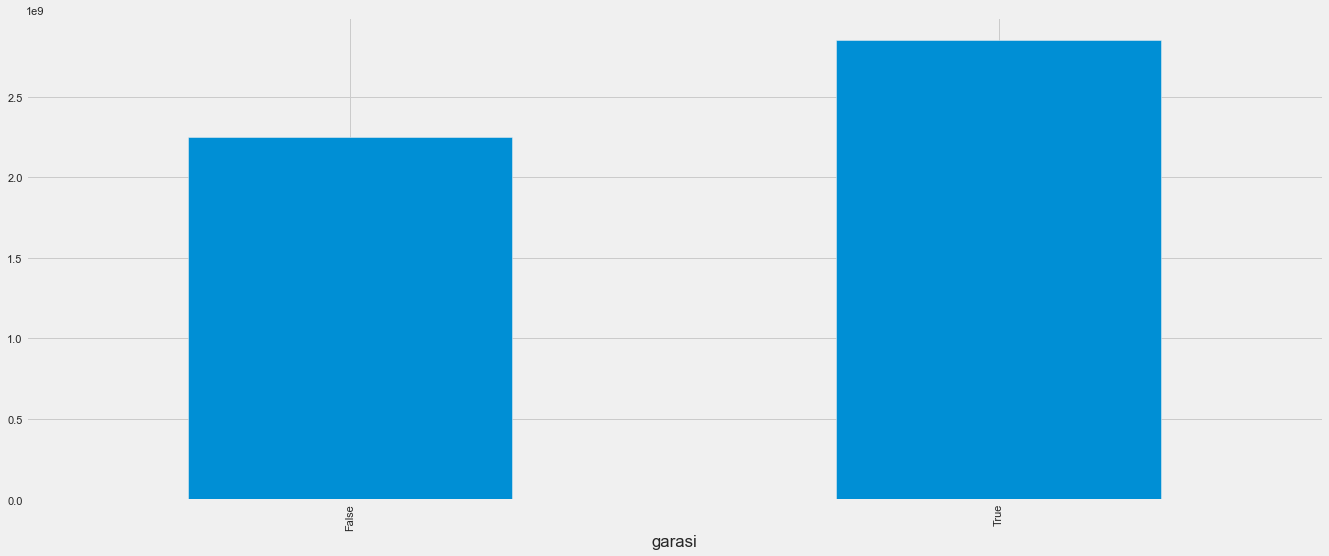

kolam_renang


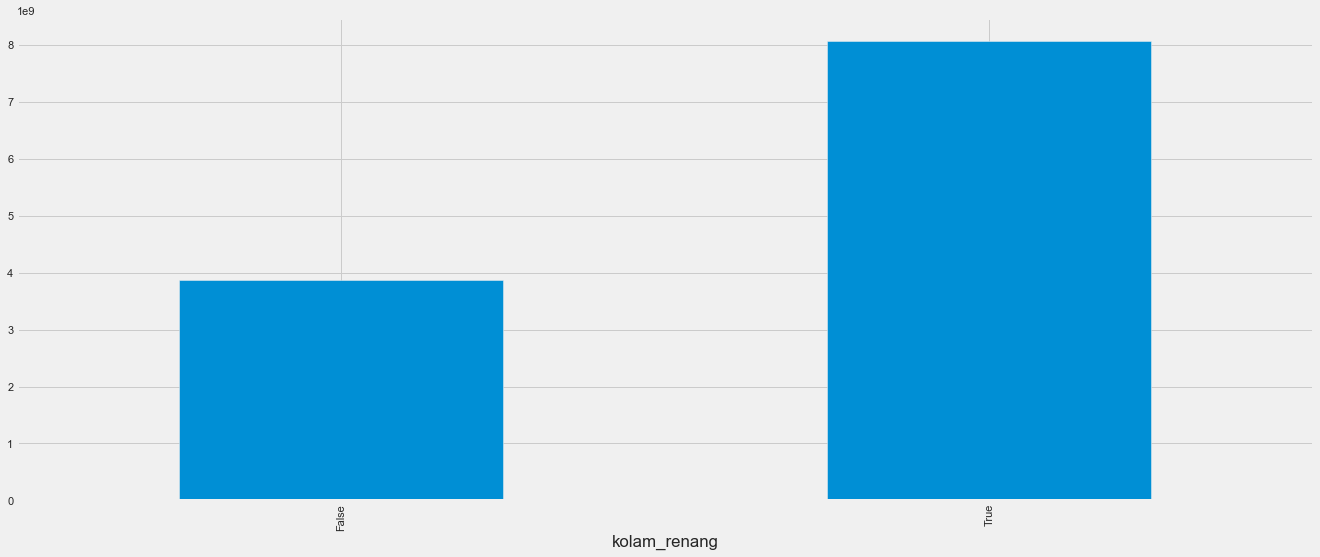

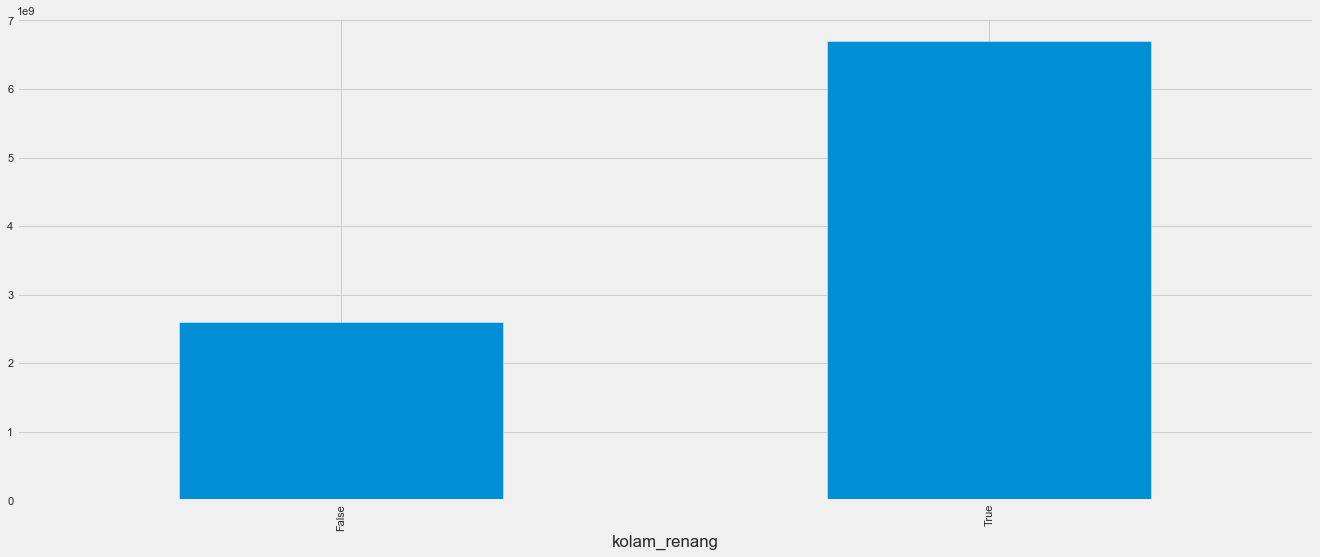

taman


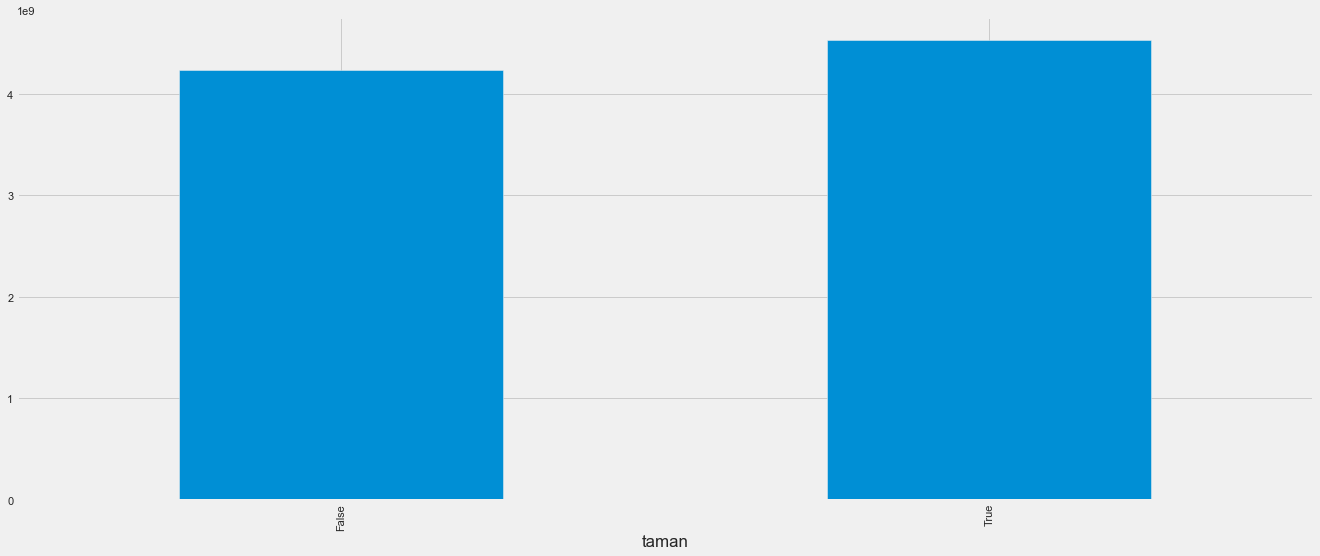

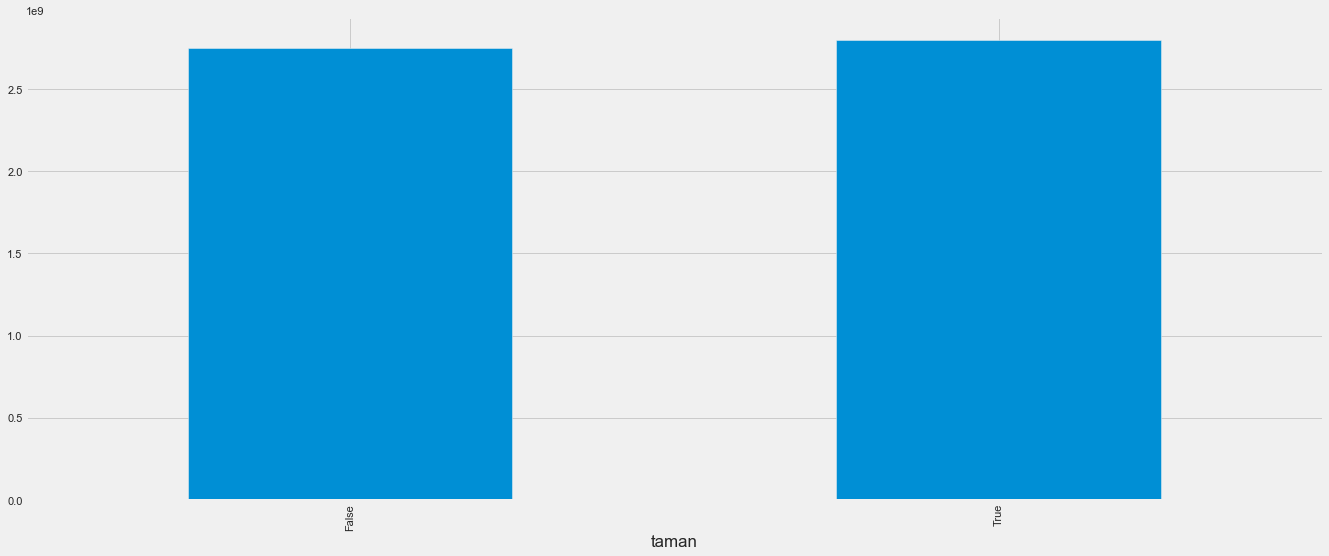

gym


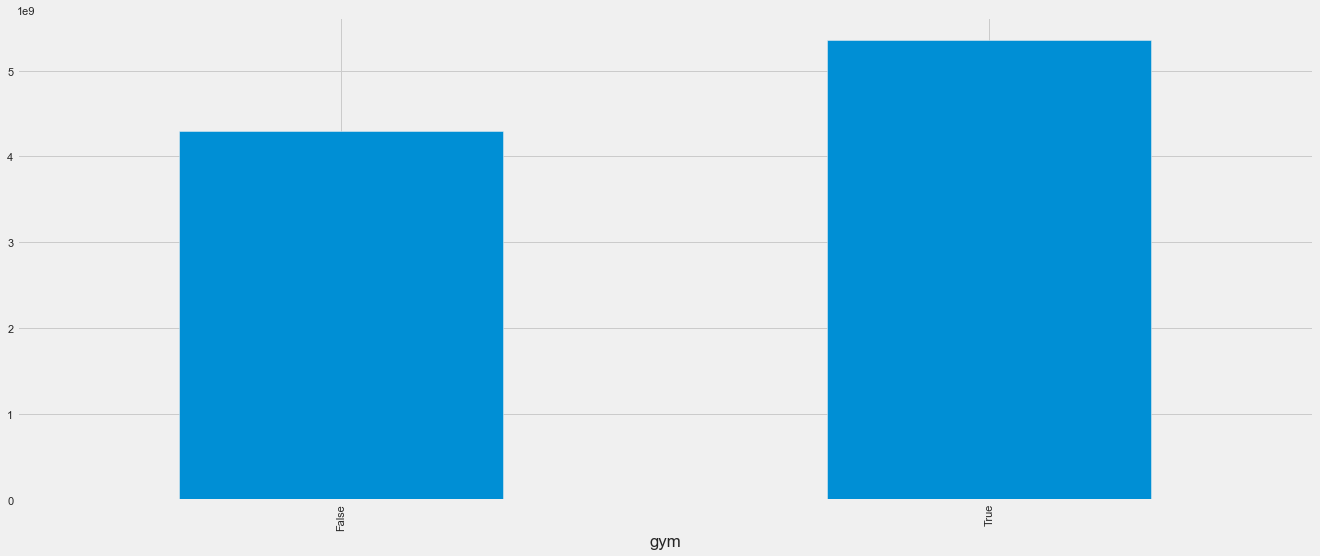

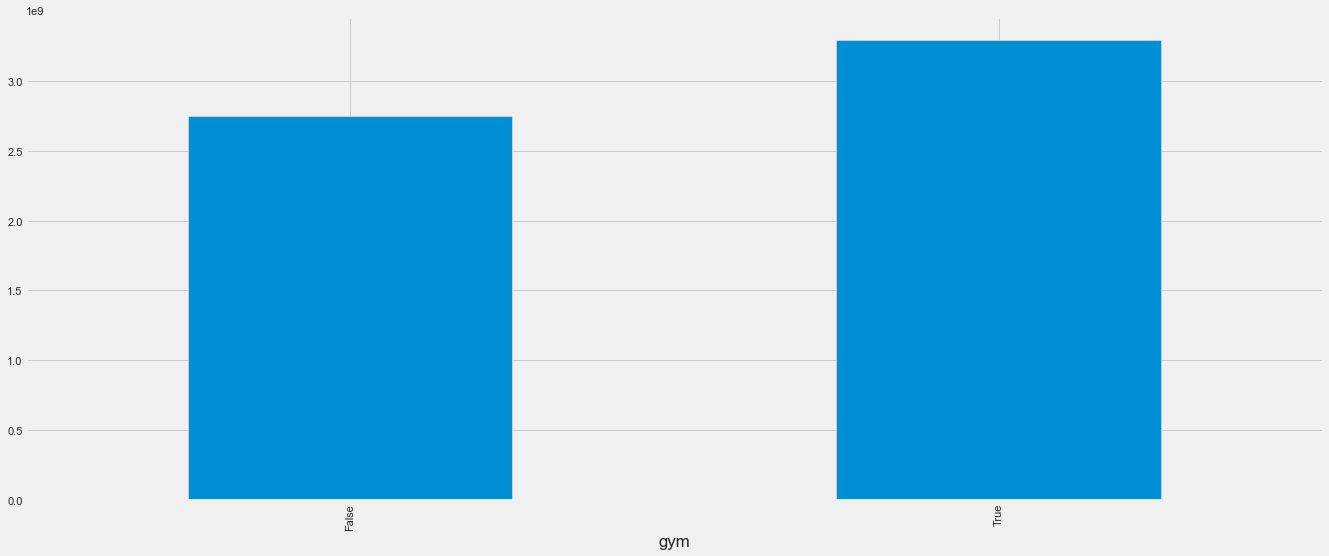

In [27]:
for i in cat:
    print(i)
    df.groupby(i)['harga'].mean().sort_values().plot.bar()
    plt.show()
    df.groupby(i)['harga'].median().sort_values().plot.bar()
    plt.show()

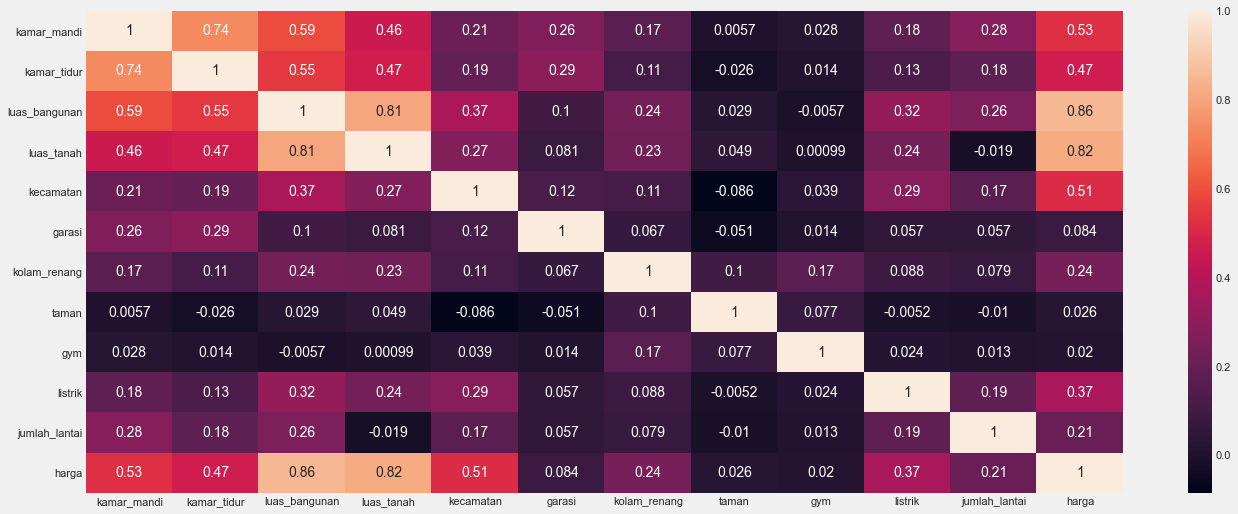

In [28]:
sns.heatmap(initial_data.corr(method = 'spearman'),annot=True)
plt.show()

In [29]:
df_experiment = df.copy()
df_experiment = df_experiment.drop(
    ['garasi','jumlah_lantai','gym'],  axis = 1
)

In [30]:
df_experiment.describe()

,kamar_mandi,kamar_tidur,luas_bangunan,luas_tanah,harga,listrik
count,11821.000000,11821.000000,11821.000000,11821.000000,1.182100e+04,11821.000000
mean,3.705609,4.589121,227.648930,190.986803,4.300666e+09,5437.207004
std,1.476824,1.838932,185.925951,199.887616,4.153040e+09,8069.204516
min,1.000000,1.000000,21.000000,22.000000,9.500000e+07,130.000000
25%,3.000000,4.000000,110.000000,90.000000,1.575000e+09,2200.000000
50%,4.000000,4.000000,178.000000,132.000000,2.795000e+09,2200.000000
75%,4.000000,5.000000,300.000000,222.000000,5.500000e+09,4400.000000
max,28.000000,43.000000,6075.000000,7000.000000,2.140400e+10,85000.000000


In [31]:
cat = [i for i in df_experiment.columns if df_experiment[i].dtypes =='O']

In [32]:
oe = OE(variables = [i for i in cat])
oe.fit(df_experiment,df_experiment['harga'])

OrdinalEncoder(variables=['kecamatan', 'kolam_renang', 'taman'])

In [33]:
x = oe.transform(df_experiment)

In [34]:
x_scale = ss()
x_scale.fit(x.drop('harga',axis = 1))
y_scale = ss()
y_scale.fit(x[['harga']])

StandardScaler()

In [35]:
x = x_scale.transform(x.drop(['harga'],axis = 1))
y = y_scale.transform(df_experiment[['harga']])
x = pd.DataFrame(x)
y = pd.DataFrame(y)
x.columns = df_experiment.drop('harga', axis = 1).columns
y.columns = ['harga']
initial_data = pd.concat([x,y],axis = 1)
x = sm.add_constant(x)

In [36]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  harga   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2806.
Date:                Sat, 22 May 2021   Prob (F-statistic):               0.00
Time:                        10:57:22   Log-Likelihood:                -10479.
No. Observations:               11821   AIC:                         2.098e+04
Df Residuals:                   11812   BIC:                         2.104e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.633e-17      0.005  -1.41e-14      1.000      -0.011       0.011
kamar_mandi       0.0688      0.008      8.661      0.000       0.053       0.084
kamar_tidur       0.0137      0.008      1.812      0.070      -0.001       0.029
luas_bangunan     0.3921      0.008     46.257      0.000       0.375       0.409
luas_tanah        0.2610      0.008     33.921      0.000       0.246       0.276
kecamatan         0.2796      0.006     48.511      0.000       0.268       0.291
kolam_renang      0.0978      0.006     17.297      0.000       0.087       0.109
taman             0.0201      0.005      3.676      0.000       0.009       0.031
listrik           0.0175      0.006      3.168      0.002       0.007       0.028
==============================================================================
Omnibus:                    12661.723   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15303317.674
Skew:                          -4.427   Prob(JB):                         0.00
Kurtosis:                     179.045   Cond. No.                         3.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

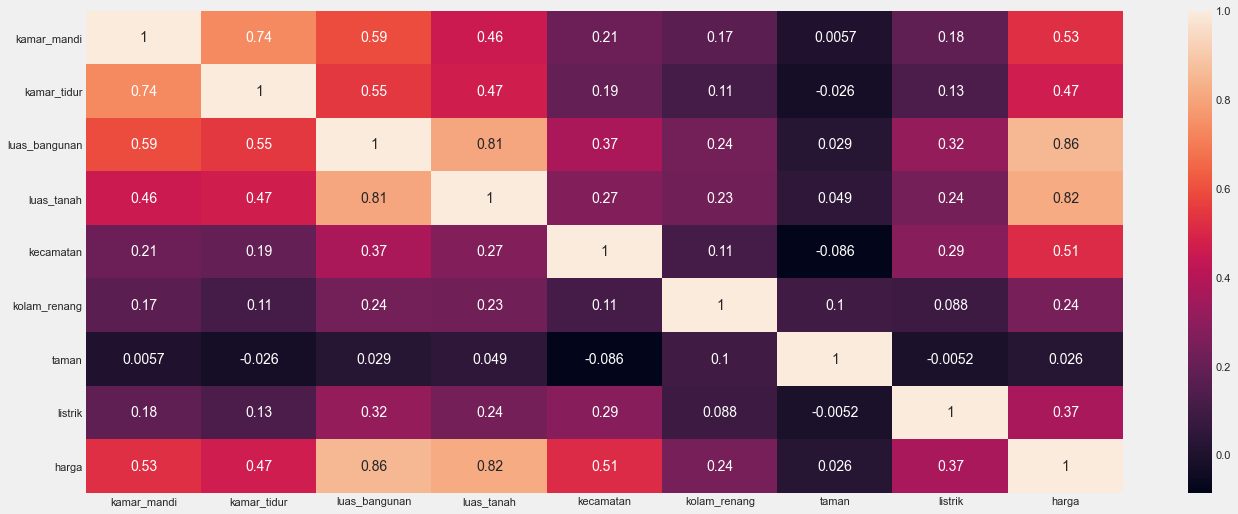

In [37]:
sns.heatmap(initial_data.corr(method = 'spearman'),annot=True)
plt.show()

In [38]:
pd.DataFrame(model.params).reset_index().sort_values(by = 0, ascending = False)

,index,0
3,luas_bangunan,3.920604e-01
5,kecamatan,2.795940e-01
4,luas_tanah,2.609831e-01
6,kolam_renang,9.784321e-02
1,kamar_mandi,6.878616e-02
7,taman,2.011475e-02
8,listrik,1.746259e-02
2,kamar_tidur,1.372072e-02
0,const,-7.632783e-17
